In [1]:
!pip install pytorch_tabnet scikit-learn pandas

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



data = pd.read_csv('Funda_dataset_cleaned.csv')
data.drop(['Aangeboden sinds', 'Verkoopdatum'],axis=1,inplace =True)
data.drop_duplicates(inplace=True)



corr_matrix = data.corr()

# Select the variables that have a correlation less than 0.1 with the target variable
drop_list = corr_matrix[corr_matrix['Laatste vraagprijs'].abs() < 0.1].index.to_list()


data = data.drop(drop_list, axis=1)


from sklearn.preprocessing import StandardScaler


numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in data.columns if data[col].dtype == 'O' and data[col].nunique() < 1000]
# Print the selected categorical columns
print("Categorical Columns:")
print(categorical_col)

# Select numerical columns
numerical_col = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]
# Print the selected numerical columns
print("Numerical Columns:")
print(numerical_col)

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)])

# Define  eval_set_pipe using the preprocessor
eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])



selected_columns = ['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis',
                     'Laatste vraagprijs', 'Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2',
                     'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2',
                     'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica',
                     'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur',
                     'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming',
                     'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard',
                     'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin',
                     'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder','Laatste vraagprijs']

selected_data = data[selected_columns]

X = data.drop('Laatste vraagprijs',axis=1)
y = data['Laatste vraagprijs']
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)




categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns


numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying the transformations
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the parameter grid for randomized search
param_dist = {
    'n_d': [8, 16],
    'n_a': [8, 16],
    'n_steps': [3, 5],
    'gamma': [0.1, 1.0],
    'lambda_sparse': [1e-4, 1e-3],
    'optimizer_params': [{'lr': 1e-2}, {'lr': 2e-2}],
    'mask_type': ['sparsemax', 'entmax'],
    'scheduler_params': [{'max_lr': 0.01, 'steps_per_epoch': 50, 'epochs': 10},
                         {'max_lr': 0.05, 'steps_per_epoch': 100, 'epochs': 20}],
}

# Create a TabNetRegressor
regressor = TabNetRegressor()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    regressor, param_distributions=param_dist, cv=3, scoring='neg_mean_squared_error', n_iter=10, n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(
    X_train_preprocessed, y_train.values.reshape(-1, 1),
    eval_set=[(X_test_preprocessed, y_test.values.reshape(-1, 1))],
    max_epochs=50,
    eval_metric=['mae', 'mse', 'rmse']
)

# Get the best model from the RandomizedSearchCV object
best_model = random_search.best_estimator_

# Make predictions on the test set with the best model
y_test_pred_tabnet = best_model.predict(X_test_preprocessed)

# Calculate metrics on the original scale
y_test_pred_original_scale = np.expm1(y_test_pred_tabnet)
y_test_original_scale = np.expm1(y_test)

mae = mean_absolute_error(y_test_original_scale, y_test_pred_original_scale)
mse = mean_squared_error(y_test_original_scale, y_test_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_test_pred_original_scale)

print("TabNet - Best Model - MAE:", mae, "MSE:", mse, "R2 Score:", r2)
print("Best Hyperparameters:", random_search.best_params_)


C:\Users\admin\AppData\Local\Temp\ipykernel_4144\706292560.py:43: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Laatste vraagprijs', 'Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder', 'Laatste 

C:\Users\admin\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 130.12752| val_0_mae: 11.17339| val_0_mse: 125.02178| val_0_rmse: 11.18131|  0:00:01s
epoch 1  | loss: 67.58666| val_0_mae: 8.83644 | val_0_mse: 78.28441| val_0_rmse: 8.84785 |  0:00:03s
epoch 2  | loss: 20.33432| val_0_mae: 5.71037 | val_0_mse: 32.93514| val_0_rmse: 5.73891 |  0:00:05s
epoch 3  | loss: 4.34457 | val_0_mae: 3.82938 | val_0_mse: 14.96475| val_0_rmse: 3.86843 |  0:00:07s
epoch 4  | loss: 1.71295 | val_0_mae: 2.74179 | val_0_mse: 7.78721 | val_0_rmse: 2.79056 |  0:00:09s
epoch 5  | loss: 0.79774 | val_0_mae: 1.10265 | val_0_mse: 1.39908 | val_0_rmse: 1.18283 |  0:00:11s
epoch 6  | loss: 0.41181 | val_0_mae: 0.74338 | val_0_mse: 0.71929 | val_0_rmse: 0.84811 |  0:00:13s
epoch 7  | loss: 0.29634 | val_0_mae: 0.87626 | val_0_mse: 0.86275 | val_0_rmse: 0.92884 |  0:00:15s
epoch 8  | loss: 0.20685 | val_0_mae: 0.38387 | val_0_mse: 0.19341 | val_0_rmse: 0.43979 |  0:00:17s
epoch 9  | loss: 0.15286 | val_0_mae: 0.24046 | val_0_mse: 0.08243 | val_0_rmse: 0.28711 

C:\Users\admin\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet - Best Model - MAE: 16974.09392405064 MSE: 913725746.6720899 R2 Score: 0.9820118996547511
Best Hyperparameters: {'scheduler_params': {'max_lr': 0.01, 'steps_per_epoch': 50, 'epochs': 10}, 'optimizer_params': {'lr': 0.02}, 'n_steps': 3, 'n_d': 8, 'n_a': 8, 'mask_type': 'entmax', 'lambda_sparse': 0.001, 'gamma': 0.1}


In [2]:
rmse = np.sqrt(mse)
print(rmse)

30227.896828461122


C:\Users\admin\AppData\Local\Temp\ipykernel_4144\643778191.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
C:\Users\admin\AppData\Local\Temp\ipykernel_4144\643778191.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('

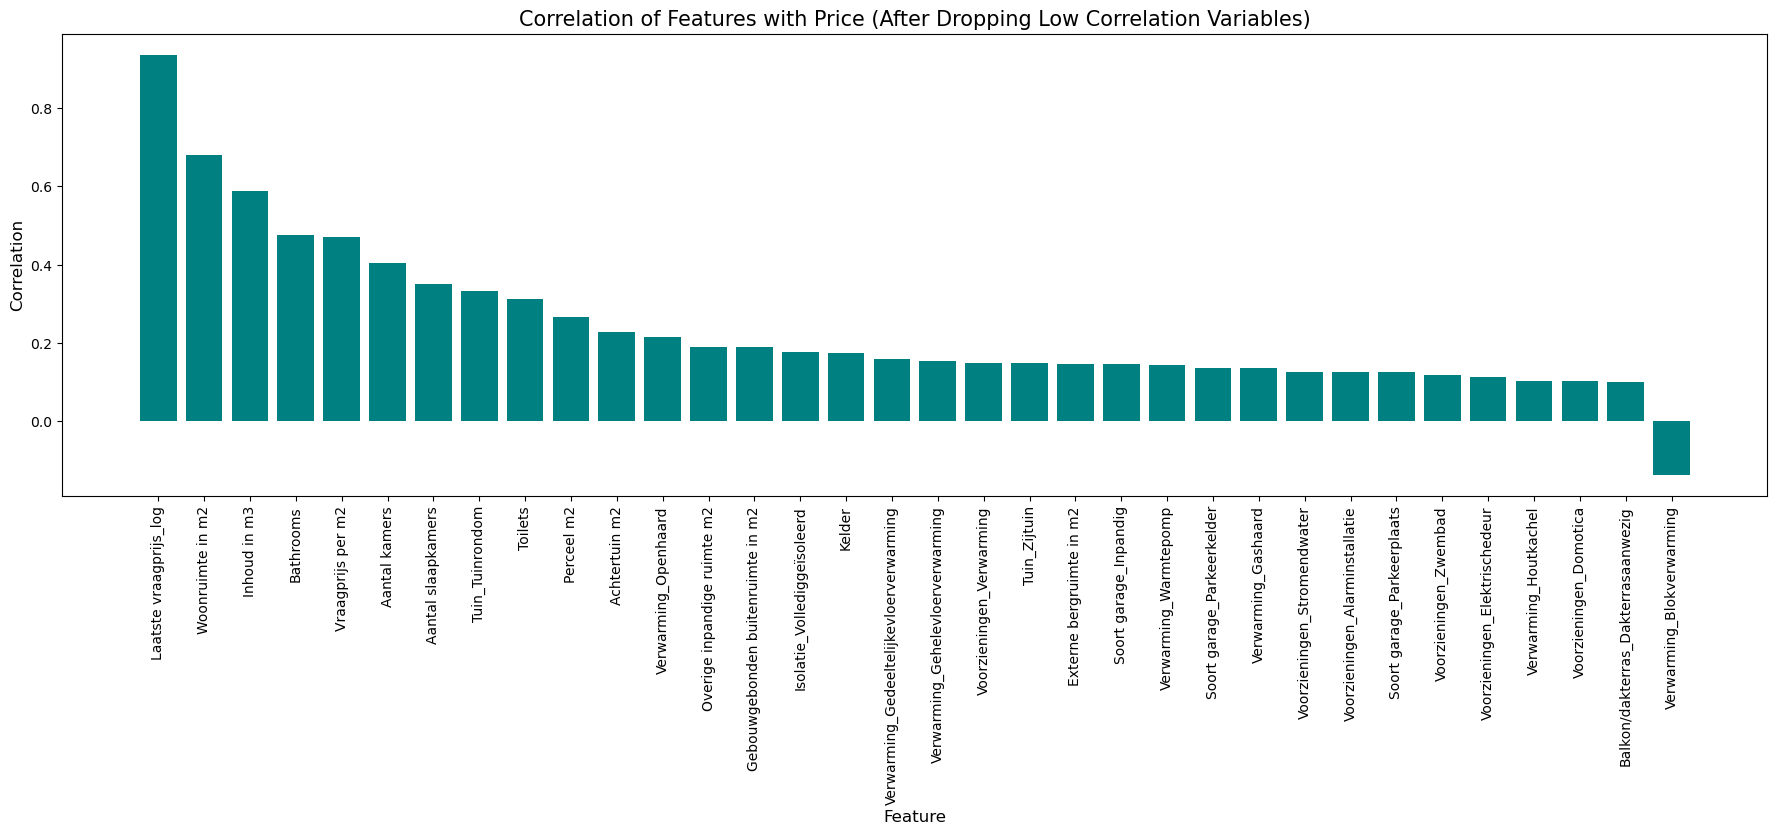

In [3]:

# plt.figure(figsize=(22,6))
# plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
# plt.xticks(rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Correlation', fontsize=12)
# plt.title('Correlation of Features with Price (After Dropping Low Correlation Variables)', fontsize=15)
# plt.savefig('correlation features.png')

# # Show the plot
# plt.show()

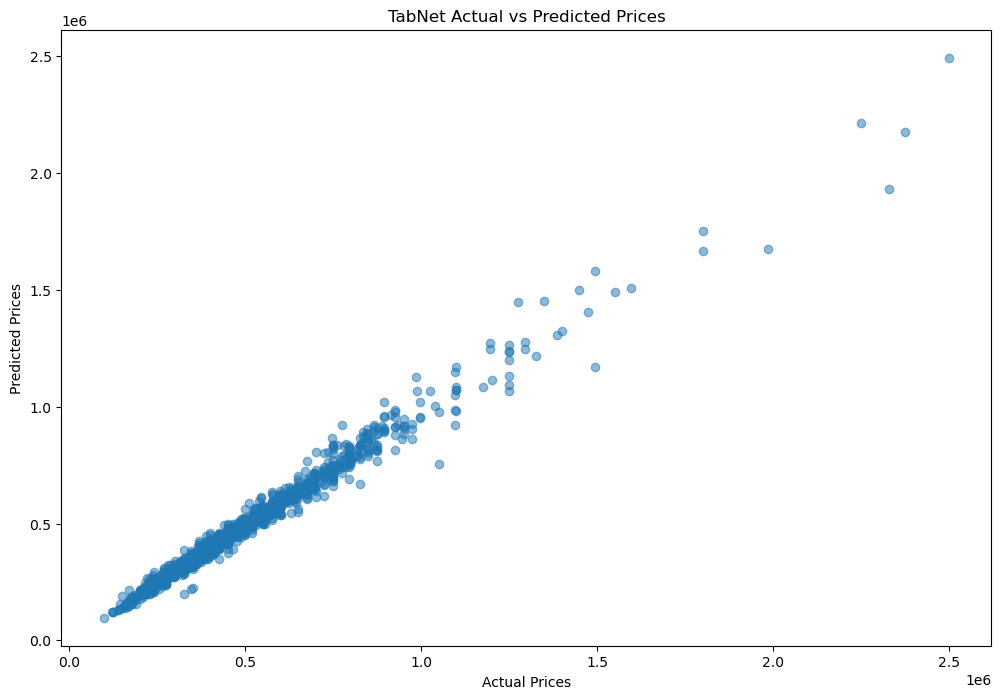

In [4]:
import matplotlib.pyplot as plt


y_test_pred_flattened = y_test_pred_original_scale.ravel()
y_test_flattened = y_test_original_scale.values.ravel()

comparison_df = pd.DataFrame({
    'Actual_Price': y_test_flattened,
    'Predicted_Price': y_test_pred_flattened
})


dpi = 300
figsize = (12, 8)
# Create the scatter plot
plt.figure(figsize=figsize)
plt.scatter(comparison_df['Actual_Price'], comparison_df['Predicted_Price'], alpha=0.5)
plt.title('TabNet Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Save the scatter plot in good resolution
plt.savefig('scatter_plot.png', dpi=dpi, bbox_inches='tight')


plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_4144\2690997412.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Actual Value", color="r", shade=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_4144\2690997412.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_pred_tabnet, label="Predicted Values", color="b", shade=True)


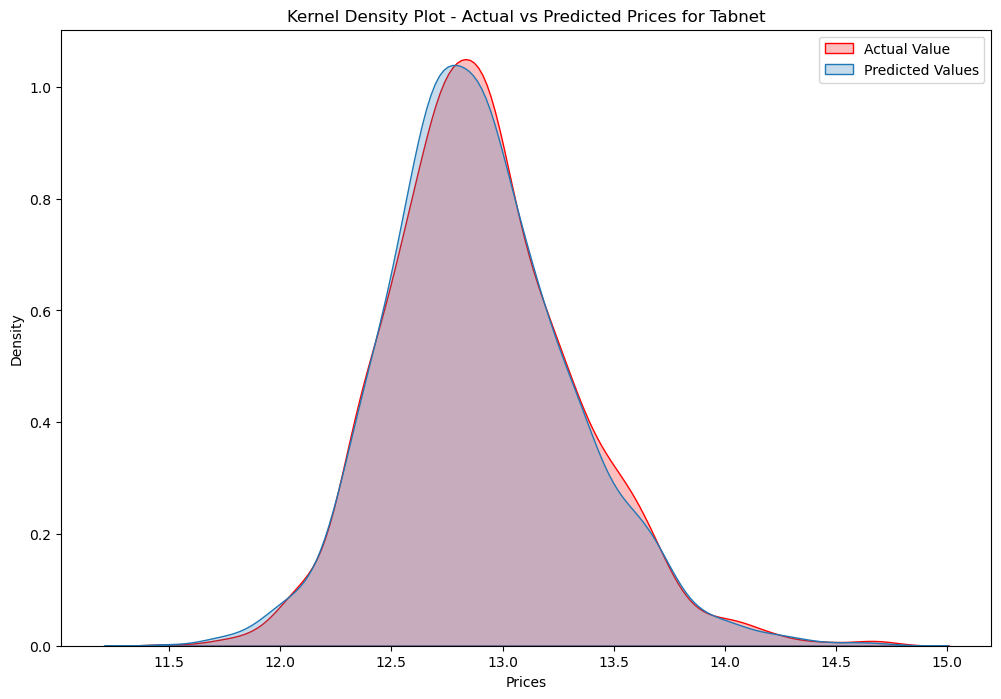

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the resolution and size
dpi = 300  
figsize = (12, 8)  

# Create the density plot using Seaborn
plt.figure(figsize=figsize)
sns.kdeplot(y_test, label="Actual Value", color="r", shade=True)
sns.kdeplot(y_test_pred_tabnet, label="Predicted Values", color="b", shade=True)
plt.title('Kernel Density Plot - Actual vs Predicted Prices for Tabnet')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()

# Save the density plot in good resolution
plt.savefig('density_plot.png', dpi=dpi, bbox_inches='tight')


plt.show()


In [9]:
import plotly.graph_objects as go

feature_importance = best_model.feature_importances_




numerical_feature_names = preprocessor.transformers_[0][2]

# Get the names of the categorical features after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out()


feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Sort features based on importance
sorted_idx = np.argsort(feature_importance)

# Select the top 20 features
top_20_idx = sorted_idx[-39:]

# Create a bar plot using Plotly
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=feature_importance[top_20_idx],
        y=np.array(feature_names)[top_20_idx],
        orientation='h',
        marker=dict(
            color=feature_importance[top_20_idx],
            colorscale='Viridis',
            cmin=min(feature_importance),
            cmax=max(feature_importance),
            colorbar=dict(title='Feature Importance'),
        ),
        text=feature_importance[top_20_idx],
        hoverinfo='text+x+y',
    )
)

fig.update_layout(
    title="Feature Importances - Tabnet",
    xaxis_title='Feature Importance',
    yaxis_title='Feature Name',
    height=600,
    width=1400,
)

fig.show()

plt.savefig('feature_importance_plot.png', dpi=dpi, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>